In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(1234)

In [2]:
# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimation

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

In [3]:
# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import \
    plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie

from zimmer.util import states_to_changepoints

In [4]:
# IO
run_num = 1
results_dir = os.path.join("results", "2017_10_02", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 10  # latent linear dynamics' dimension
D_in = 1       # number of input dimensions
D_obs = 477    # number of neurons (60 = number of labeled neurons)

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 1000.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0   # Gamma prior for emission variance

# Number of worms to fit
N_worms = 5

In [5]:
def cached(results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                assert os.path.exists(results_dir)
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper
    return _cache

# Load the data

In [6]:
# Load the data -- first order differences in dF/F
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
# Ys = [wd.dff_deriv for wd in worm_datas]
Ys = [wd.smoothed_diff for wd in worm_datas]

# Get the "true" discrete states as labeled by Zimmer
z_trues = [wd.zimmer_states for wd in worm_datas]
perm_z_trues, newlabels = relabel_by_usage(z_trues, return_mapping=True)
z_trues = perm_z_trues

# Get the key
z_key = load_key()
perm_z_key = [z_key[i] for i in np.argsort(newlabels)]
z_key = perm_z_key

# Get the names of the neurons
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = all_neuron_names.size
print("{} neurons across all {} worms".format(N_neurons, N_worms))

# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
print("{} shared neurons".format(len(shared_neurons)))
Ys_shared = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    Ys_shared.append(Y[:, shared_indices])

# Construct a big dataset with all neurons for each worm
datasets = []
data_masks = []
for wd in worm_datas:
    this_dataset = np.zeros((wd.T, N_neurons))
    this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
    indices = wd.find_neuron_indices(all_neuron_names)
    for n, index in enumerate(indices):
        if index is not None:
#             this_dataset[:,n] = wd.dff_deriv[:, index]
            this_dataset[:,n] = wd.smoothed_diff[:, index]
            this_mask[:,n] = True

    datasets.append(this_dataset[:,:D_obs])
    data_masks.append(this_mask[:,:D_obs])

477 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


In [7]:
train_frac = 0.9
train_masks = [np.arange(T) < train_frac * T for T in Ts]

z_trues_train = [z[train] for z,train in zip(z_trues, train_masks)]
z_trues_test = [z[~train] for z,train in zip(z_trues, train_masks)]
Ts_train = [z.shape[0] for z in z_trues_train]
Ts_test = [z.shape[0] for z in z_trues_test]
datasets_train = [d[train] for d,train in zip(datasets, train_masks)]
datasets_test = [d[~train] for d,train in zip(datasets, train_masks)]
data_masks_train = [d[train] for d,train in zip(data_masks, train_masks)]
data_masks_test = [d[~train] for d,train in zip(data_masks, train_masks)]
Ys_train = [Y[train] for Y, train in zip(Ys, train_masks)]
Ys_test = [Y[~train] for Y, train in zip(Ys, train_masks)]
Ys_shared_train = [Y[train] for Y, train in zip(Ys_shared, train_masks)]
Ys_shared_test = [Y[~train] for Y, train in zip(Ys_shared, train_masks)]

# Run PCA to justify choice of latent dimensionality

90% variance explained:  36
10 PCs capture:  0.687852999144
90% variance explained:  34
10 PCs capture:  0.708614368558
90% variance explained:  51
10 PCs capture:  0.583570293989
90% variance explained:  42
10 PCs capture:  0.607584060388
90% variance explained:  55
10 PCs capture:  0.599636287069


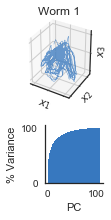

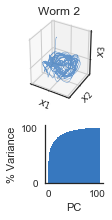

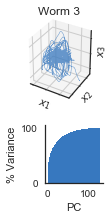

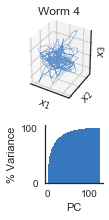

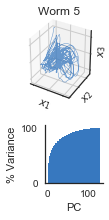

In [8]:
def plot_pca_trajectories(worm, Y):
    # Try to reproduce their plot of PC's over time
    n_comps = Y.shape[1]
    pca = PCA(n_components=n_comps, whiten=True)
    pca.fit(Y)

    x_pca = pca.transform(Y)

    fig = plt.figure(figsize=(1.5,3.))
    ax = create_axis_at_location(fig, 0.2, 1.5, 1.1, 1.25, projection="3d")
    ax.plot(x_pca[:,0], x_pca[:,1], x_pca[:,2], lw=0.5, alpha=0.75, ls='-', color=colors[0])
    ax.set_xlabel("$x_1$", labelpad=-12)
    ax.set_ylabel("$x_2$", labelpad=-12)
    ax.set_zlabel("$x_3$", labelpad=-12)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title("Worm {}".format(worm+1))

    # Plot percent variance explained
    ax = create_axis_at_location(fig, .55, 0.4, .8, .8, box=False)
    ax.patch.set_alpha(0.0)
    ax.bar(np.arange(n_comps),  100 * np.cumsum(pca.explained_variance_ratio_), width=1, color=colors[0])
#     ax.plot(np.arange(n_comps), 90 * np.ones(n_comps), ':r')
    ax.set_xlabel("PC")
    ax.set_ylabel("% Variance")

    print("90% variance explained: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .90)[0][0])
    print(str(D_latent) + " PCs capture: ", np.sum(pca.explained_variance_ratio_[:D_latent]))
#     plt.savefig(os.path.join(results_dir, "pca_trajectory_worm{}.pdf".format(worm)))
    
# Plot PCA trajectories for first worm
for i in range(N_worms):
    plot_pca_trajectories(i, Ys_train[i])

# Do the same thing but with factor analysis

In [9]:
def fit_pca(Ys_shared):
    # Try to reproduce their plot of PC's over time
    pca = PCA(n_components=D_latent, whiten=True)
    pca.fit(np.vstack(Ys_shared))

    x_inits = [pca.transform(Y) for Y in Ys_shared]
    C_init = pca.components_.T
    return x_inits, C_init


# Fit PCA and plot the latent states
x_inits, _ = fit_pca(Ys_shared_train)


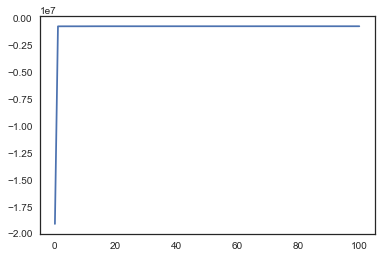

In [10]:
from zimmer.models import HierarchicalFactorAnalysis

@cached("hfa")
def fit_hierarchical_factor_analysis():
    fa = HierarchicalFactorAnalysis(N_neurons, D_latent, 1, alpha_0=alpha_0, beta_0=0.01)
    for worm in range(N_worms):
        fa.add_data(datasets_train[worm], mask=data_masks_train[worm], group=0)

    # Initialize with PCA
    for worm in range(N_worms):
        x0 = x_inits[worm]
        fa.data_list[worm].E_Z = x0
        fa.data_list[worm].E_ZZT = x0[:,:,None] * x0[:,None,:]
        fa.data_list[worm]._set_expected_stats()
    stats = [d.E_emission_stats for d in fa.data_list]
    groups = [d.group for d in fa.data_list]
    fa.regression.max_likelihood(stats=stats, groups=groups)
    
    lls = [fa.log_likelihood()]    
    for itr in progprint_xrange(100):
        fa.EM_step()
        lls.append(fa.log_likelihood())
    
    return fa, lls

fa, lls = fit_hierarchical_factor_analysis()
plt.plot(lls)

In [11]:
# Extract the smoothed latent states 
Xs_train = []
Ys_smooth_train = []
for worm in range(N_worms):
    fa.add_data(datasets_train[worm], mask=data_masks_train[worm])
    states = fa.data_list.pop()
    states.E_step()
    Xs_train.append(states.E_Z)
    Ys_smooth_train.append(states.E_Z.dot(states.W.T))
    
Xs_test = []
Ys_smooth_test = []
for worm in range(N_worms):
    fa.add_data(datasets_test[worm], mask=data_masks_test[worm])
    states = fa.data_list.pop()
    states.E_step()
    Xs_test.append(states.E_Z)
    Ys_smooth_test.append(states.E_Z.dot(states.W.T))
    

In [12]:
from pyhsmm.util.general import rle
def plot_latent_trajectories_vs_time(X, Z, colors, plot_slice=(0, 500), alpha=0.5, title=None):
    z_rle = rle(Z)
    lim = 1.1 * abs(X).max()
    Xnorm = X / (2 * lim)
    
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    
    # Plot z in background
    offset = 0
    for k, dur in zip(*z_rle):
        ax.fill_between([offset, offset+dur], [-D_latent, -D_latent], [0, 0], 
                        color=colors[k], alpha=alpha)
        offset += dur
        if offset > plot_slice[1]:
            break

        # Plot x
    for d in range(D_latent):
        ax.plot(Xnorm[:, d] - d - 0.5, '-k', lw=2)
        ax.plot(plot_slice, (-d - 0.5) * np.ones(2), ':k', lw=1)
        
    ax.set_xlim(plot_slice)
    ax.set_xlabel("Time")   
    ax.set_title(title)
    ax.set_yticks(-1 * np.arange(D_latent) - 0.5)
    ax.set_yticklabels(["$x_{{{}}}$".format(d+1) for d in range(D_latent)])
    ax.set_ylim(-D_latent, 0)
    plt.tight_layout()

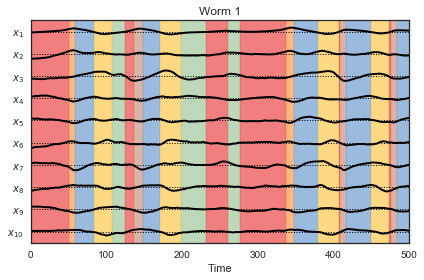

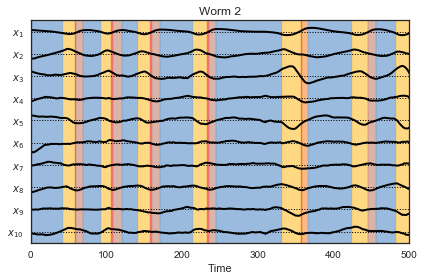

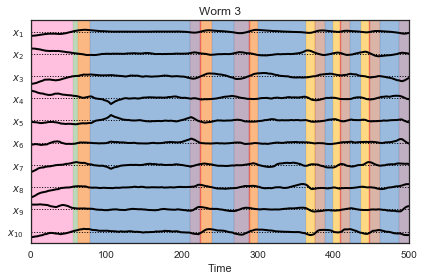

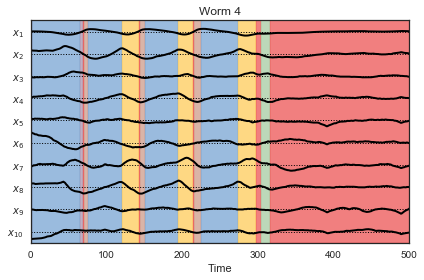

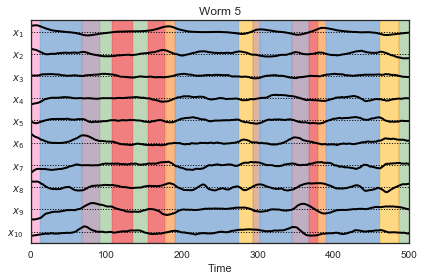

In [13]:
for worm in range(N_worms):
    plot_latent_trajectories_vs_time(Xs_train[worm], z_trues_train[worm], 
                                     colors, title="Worm {}".format(worm+1))

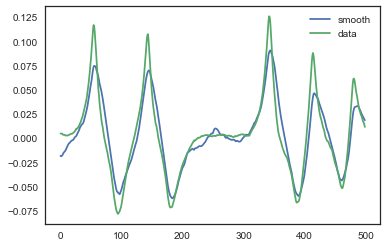

In [14]:
plt.plot(Ys_smooth_train[0][:500, 6], label="smooth")
plt.plot(datasets_train[0][:500, 6], label="data")
plt.legend()

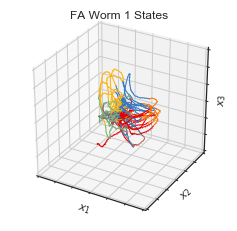

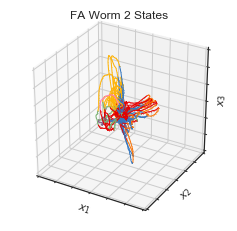

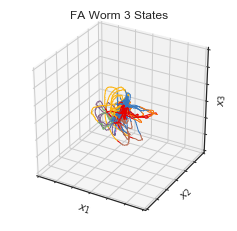

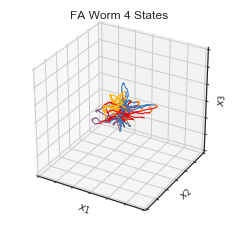

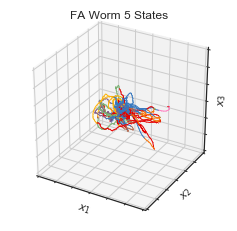

In [15]:
for worm in range(N_worms):
    plot_3d_continuous_states(Xs_train[worm], z_trues_train[worm], colors,
                              figsize=(4, 4),
                              title="FA Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="x_fa_zimmer_worm{}.pdf".format(worm + 1),
                              lim=6,
                              lw=1)

100%|██████████| 360/360 [00:32<00:00, 10.55it/s]


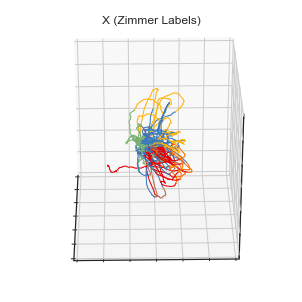

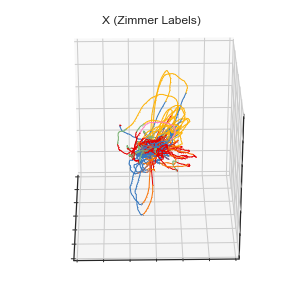

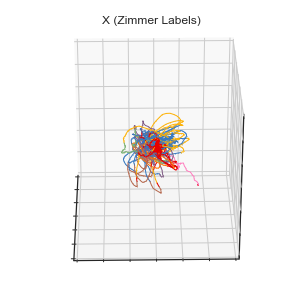

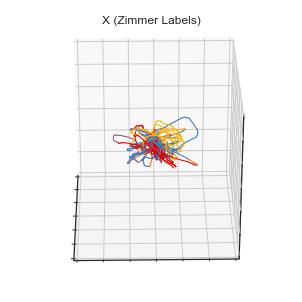

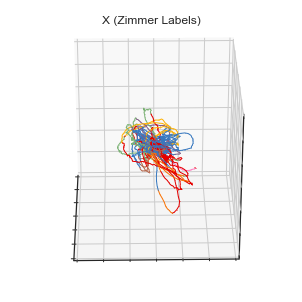

In [16]:
for worm in range(N_worms):
    make_states_3d_movie(z_trues_train[worm], Xs_train[worm],
                         title="X (Zimmer Labels)",
                         filepath=os.path.join(results_dir, "x_fa_zimmer_worm{}.mp4".format(worm+1)),
                         lim=6)

# Now fit Xs with an AR-HMM

In [14]:
from autoregressive.models import ARWeakLimitStickyHDPHMM, ARWeakLimitHDPHSMM
from pyslds.util import get_empirical_ar_params
from pybasicbayes.distributions import AutoRegression, RobustAutoRegression
from pyhsmm.basic.distributions import NegativeBinomialFixedRDuration, NegativeBinomialIntegerRDuration

In [31]:
Kmax = 15
nlags = 1

ar_params = dict(nu_0=D_latent+2,
                 S_0=np.eye(D_latent),
                 M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_latent * (nlags-1) + 1)))),
                 K_0=np.eye(D_latent*nlags+1),
                 affine=True)
ar_params = get_empirical_ar_params(Xs_train, ar_params)

model = ARWeakLimitStickyHDPHMM(
        alpha=alpha, gamma=gamma, kappa=1000, 
        init_state_distn='uniform',
        obs_distns=[RobustAutoRegression(**ar_params) for state in range(Kmax)])

# Initialize discrete states with runs
for X in Xs_train:
    T = X.shape[0]
    runlen = 100
    z0 = np.arange(np.ceil(T / float(runlen))) % Kmax 
    z0 = z0.repeat(runlen)[:T-nlags]
    model.add_data(X, stateseq=z0.astype(np.int32))

#  Fit the model with Gibbs
lls = []
raw_z_smpls = []
for itr in progprint_xrange(2000):
    model.resample_model()
    lls.append(model.log_likelihood())
    raw_z_smpls.append(model.stateseqs)

z_smpls = []
for w in range(N_worms):
    z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
    z_smpls.append(z_smpls_w)
    
perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
perm = np.argsort(iperm)
z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in model.states_list]

print(model.state_usages)

.........................  [   25/2000,    0.09sec avg, ETA 03:03 ]
.........................  [   50/2000,    0.09sec avg, ETA 02:55 ]
.........................  [   75/2000,    0.09sec avg, ETA 02:50 ]
.........................  [  100/2000,    0.09sec avg, ETA 02:46 ]
.........................  [  125/2000,    0.09sec avg, ETA 02:43 ]
.........................  [  150/2000,    0.09sec avg, ETA 02:41 ]
.........................  [  175/2000,    0.09sec avg, ETA 02:40 ]
.........................  [  200/2000,    0.09sec avg, ETA 02:38 ]
.........................  [  225/2000,    0.09sec avg, ETA 02:36 ]
.........................  [  250/2000,    0.09sec avg, ETA 02:35 ]
.........................  [  275/2000,    0.09sec avg, ETA 02:33 ]
.........................  [  300/2000,    0.09sec avg, ETA 02:38 ]
.........................  [  325/2000,    0.09sec avg, ETA 02:37 ]
.........................  [  350/2000,    0.10sec avg, ETA 02:38 ]
.........................  [  375/2000,    0.10s

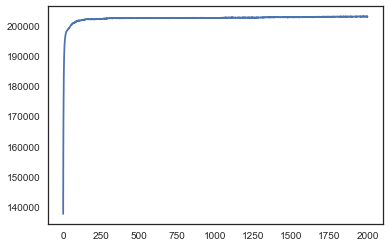

In [32]:
plt.plot(lls)

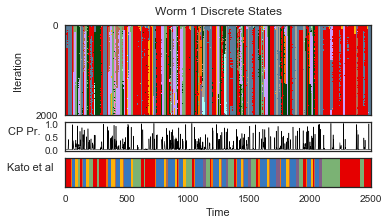

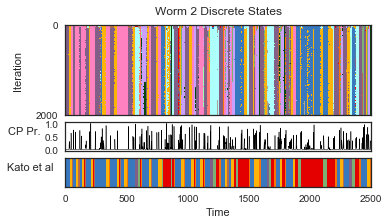

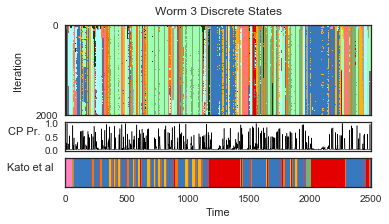

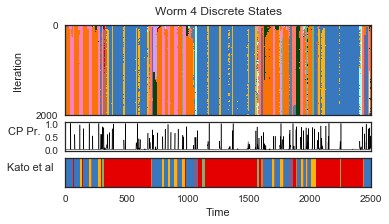

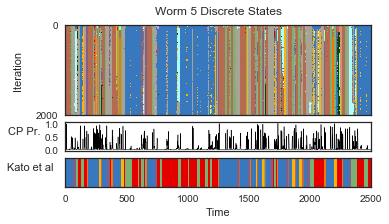

In [33]:
for worm in range(N_worms):
    plot_changepoint_prs(perm_z_smpls[worm],
                         z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         plt_slice=(0,2500),
                         filepath=os.path.join(results_dir, "arhmm_z_cps_worm{}.pdf".format(worm)))
    

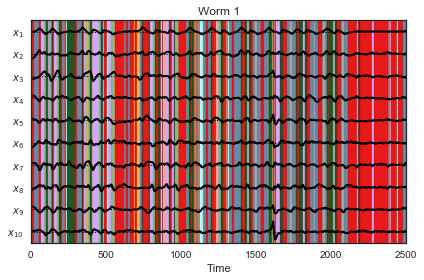

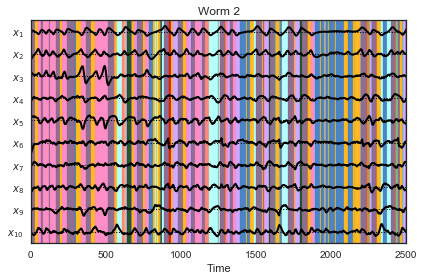

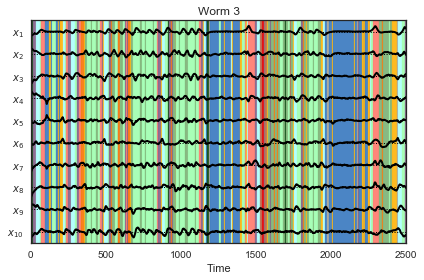

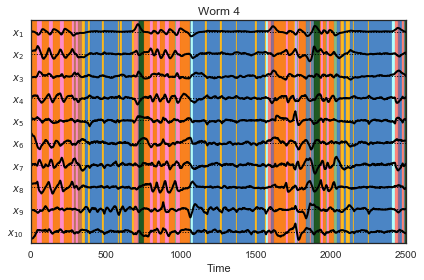

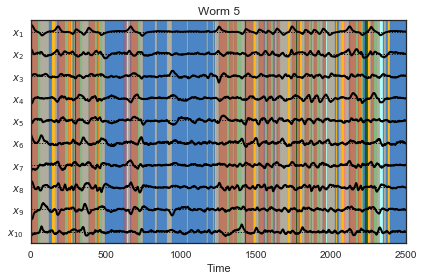

In [34]:
for worm in range(N_worms):
    plot_latent_trajectories_vs_time(Xs_train[worm], perm_z_smpls[worm][-1], 
                                     colors, title="Worm {}".format(worm+1),
                                     alpha=0.9, plot_slice=(0, 2500))

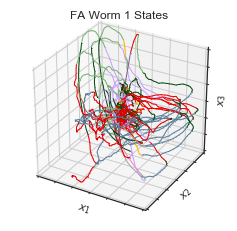

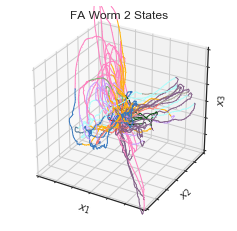

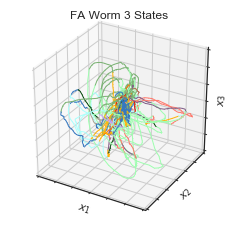

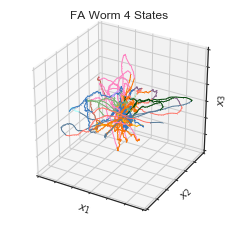

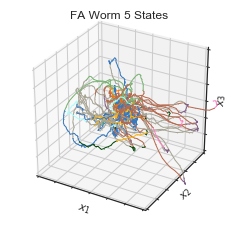

In [35]:
for worm in range(N_worms):
    plot_3d_continuous_states(Xs_train[worm], perm_z_smpls[worm][-1], colors,
                              figsize=(4, 4),
                              title="FA Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="x_fa_arhmm_worm{}.pdf".format(worm + 1),
                              lim=3,
                              lw=1)

100%|██████████| 360/360 [00:47<00:00,  8.05it/s]


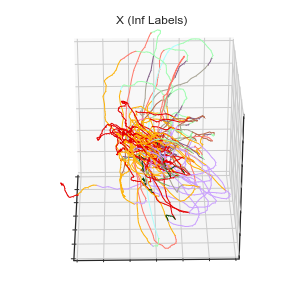

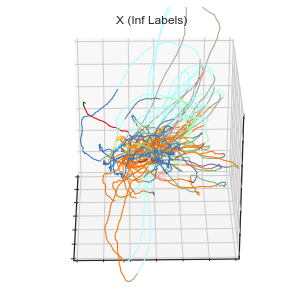

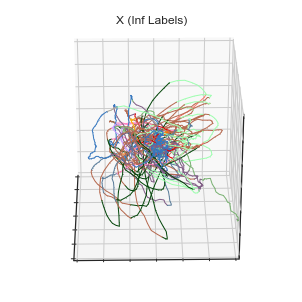

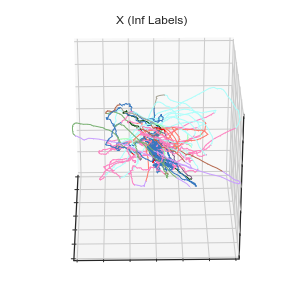

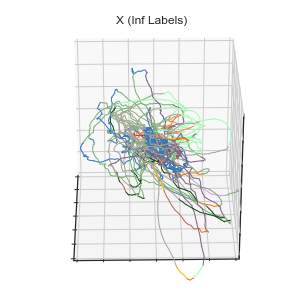

In [22]:
for worm in range(N_worms):
    make_states_3d_movie(perm_z_smpls[worm][-1], Xs_train[worm],
                         title="X (Inf Labels)",
                         filepath=os.path.join(results_dir, "x_fa_arhmm_worm{}.mp4".format(worm+1)),
                         lim=3)